In [96]:
#Install necessary packages and import the corresponding libraries
#!pip install leidenalg
#pip install --user scikit-misc
#!pip install scrublet as scr
import warnings
import leidenalg
import scanpy as sc
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scrublet as scr

In [97]:
#Read in cleaned.ts file necessary for analysis
file = '/home/jl690/Downloads/GSE67835_CPM_named_clean.tsv'
adata = sc.read_text(file, delimiter='\t').T 
#Verbosity level 3 to output higher level of detail and setting figure parameters
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')
#Ignore warnings
warnings.filterwarnings('ignore')

In [98]:
adata

AnnData object with n_obs × n_vars = 466 × 46766

In [99]:
results_file = 'brain.h5ad'

In [100]:
#Detect doublets using scr
scrub = scr.Scrublet(adata.X)
doublet_score, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3)

#Add to adata
adata.obs['scrublet_scores'] = doublet_score
adata.obs['scrublet_predicted_doublets'] = predicted_doublets

#Remove
adata = adata[~adata.obs['scrublet_predicted_doublets'], :]

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 3.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 86.7%
Elapsed time: 0.7 seconds


normalizing counts per cell
    finished (0:00:00)


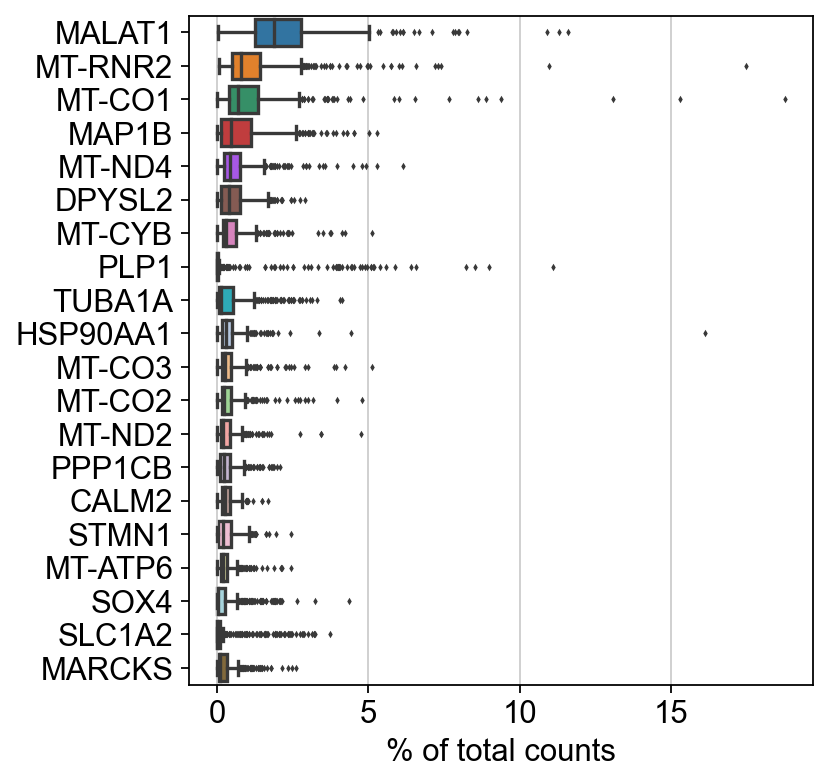

In [101]:
#Visualisation of the top 20 highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20, )

In [102]:
#Simple filtering 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

#Adding a column with a boolean whether a mitochrondrial gene is present
adata.var['mt'] = adata.var_names.str.startswith('MT-')

filtered out 11799 genes that are detected in less than 3 cells


In [103]:
# Visualising the genes which are mitochondrial
adata.var[adata.var.mt == True]

,n_cells,mt
MT-ATP6,453,True
MT-ATP8,451,True
MT-CO1,453,True
MT-CO2,453,True
MT-CO3,453,True
MT-CYB,451,True
MT-ND1,452,True
MT-ND2,453,True
MT-ND3,424,True
MT-ND4,453,True


In [104]:
#Setting parameters for ScanPy based quality control
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata

AnnData object with n_obs × n_vars = 453 × 34967
    obs: 'scrublet_scores', 'scrublet_predicted_doublets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

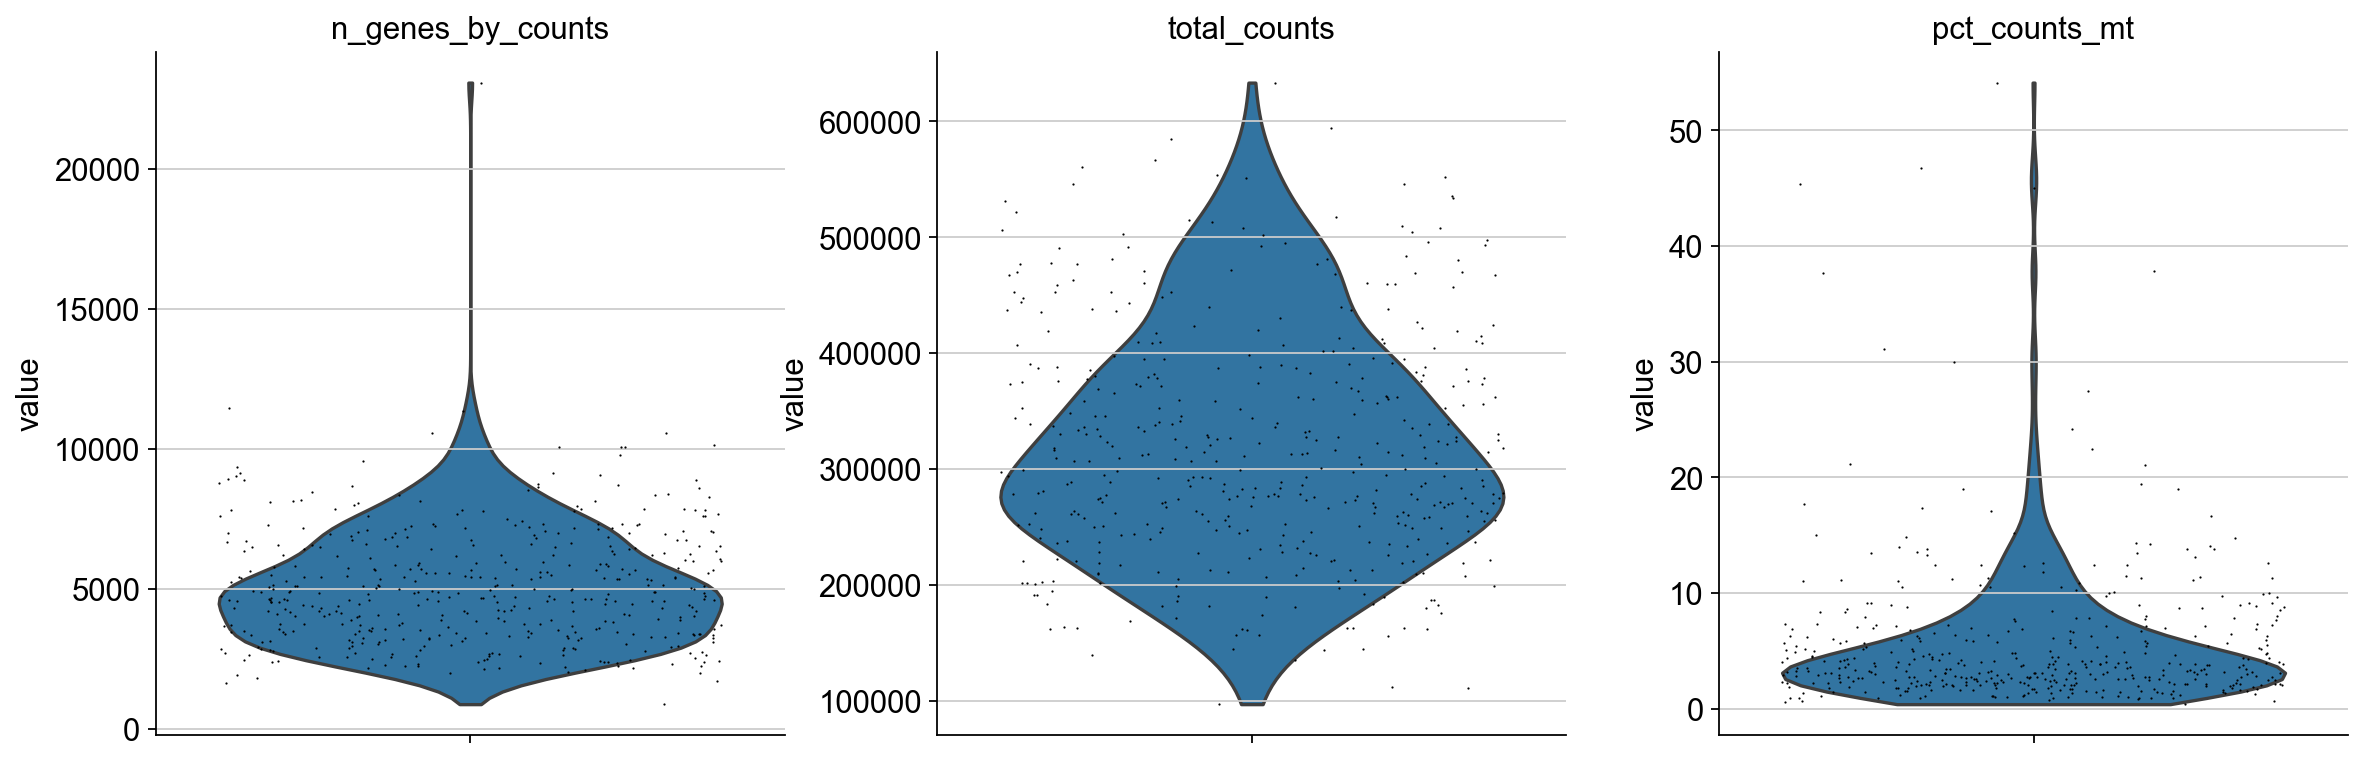

In [105]:
#Violin plots for number of genes expressed in the matrix, total counts per cell and % counts in mt cells
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [106]:
#Identifying the cell that has over 50% mitochondrial genes
adata.obs[adata.obs.pct_counts_mt > 50]

,scrublet_scores,scrublet_predicted_doublets,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
SRR1974727,0.211679,False,6215,6184,300084.9375,162458.9375,54.137653


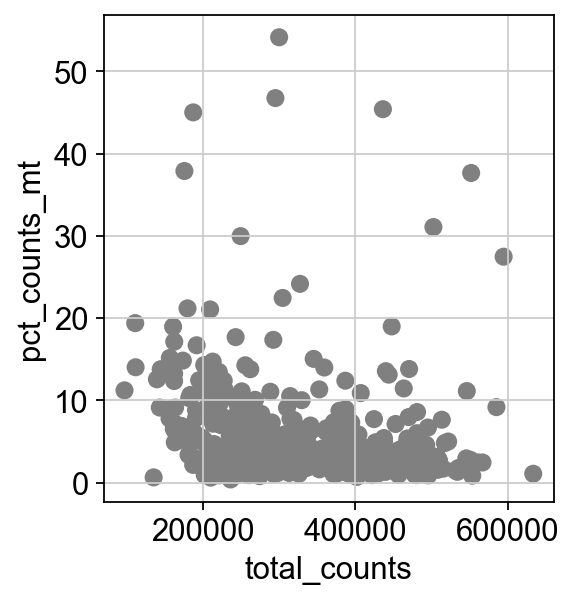

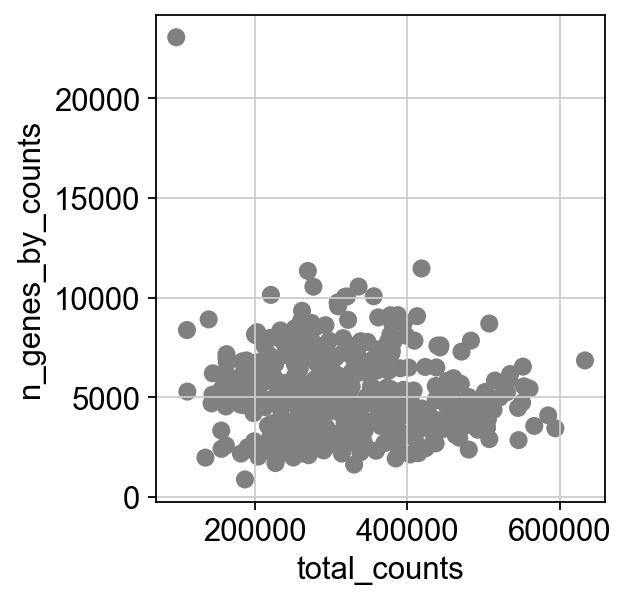

In [107]:
#Scattergraphs displaying a.) Total expression against mitochondrial gene expression b.) Total counts of each cell against no. of genes detected
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [108]:
#Selecting genes that have a % mitochondrial count of 10%
adata = adata[adata.obs.pct_counts_mt < 10, :]
#Log transformation on adata 
sc.pp.log1p(adata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


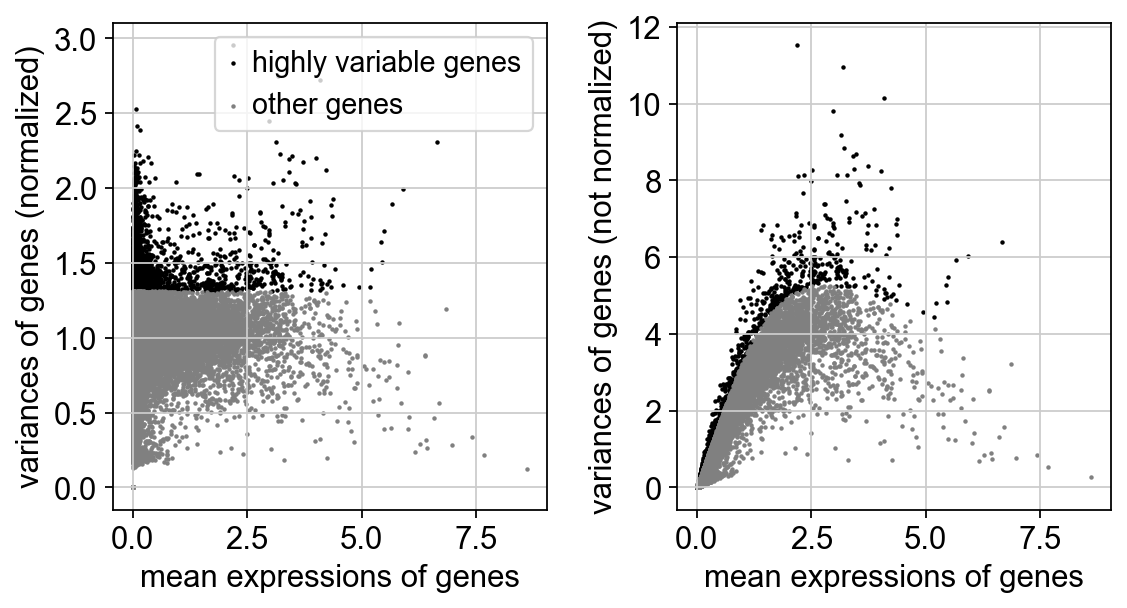

In [109]:
#Highly variable genes using default values
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3')

sc.pl.highly_variable_genes(adata)
adata.var[adata.var.highly_variable]

adata.raw = adata

In [110]:
#Filtering out the genes that aren't highly variable
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:08)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


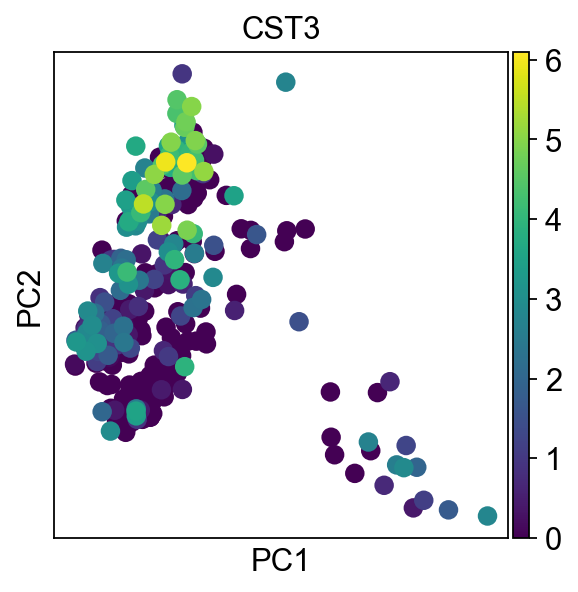

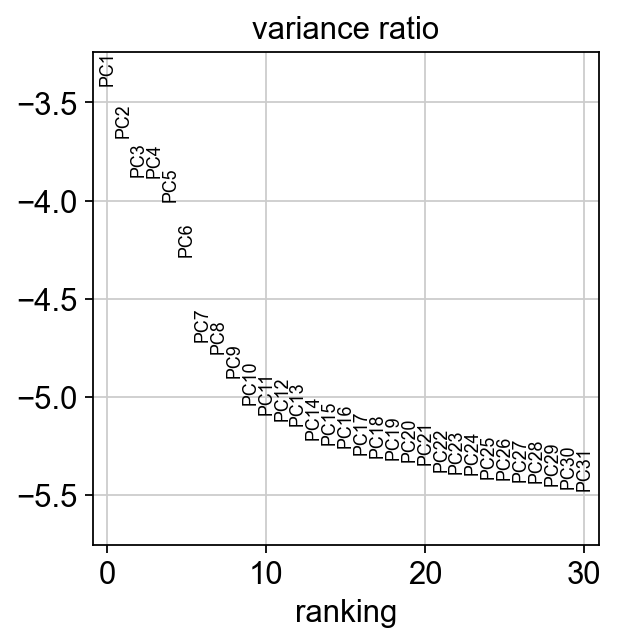

AnnData object with n_obs × n_vars = 390 × 4000
    obs: 'scrublet_scores', 'scrublet_predicted_doublets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [111]:
#Prinicipal Component Analysis

#PCA on expression matrix
sc.tl.pca(adata, svd_solver='arpack')
#Scatterplot of principal components against CST3
sc.pl.pca(adata, color='CST3')
#Log-scale line plot displaying variance
sc.pl.pca_variance_ratio(adata, log=True)
adata.write(results_file)
adata

In [112]:
#Computing elucidean-distance neughbours between cells in PCA
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)


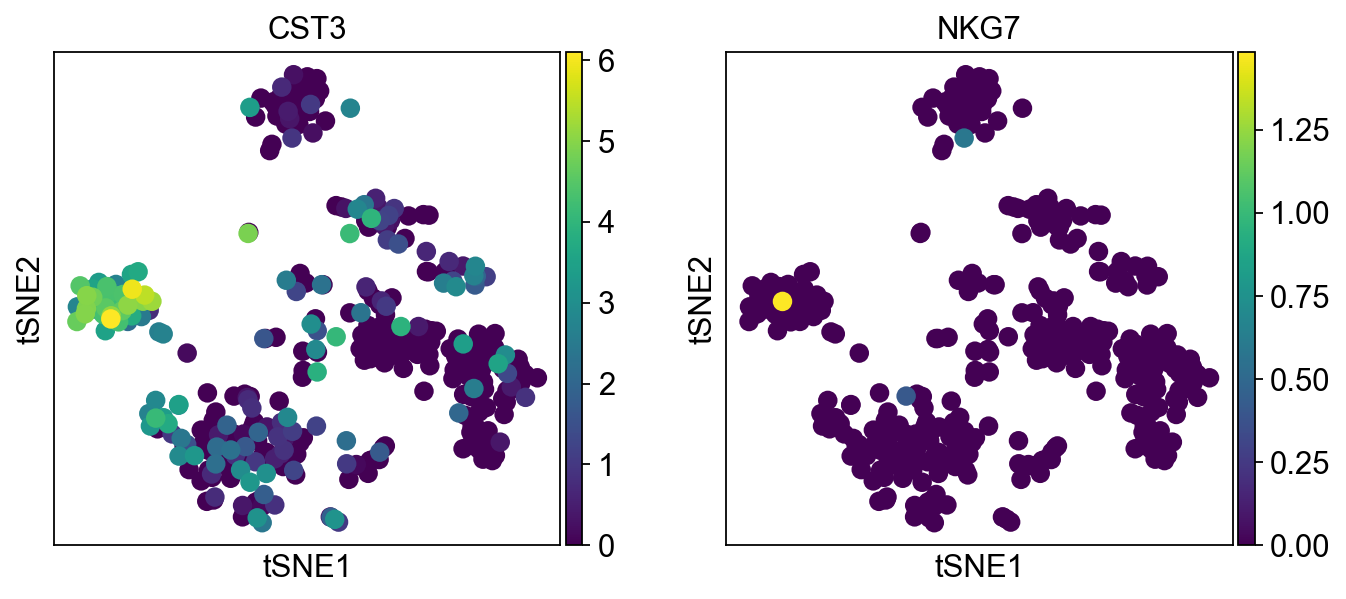

In [113]:
#t-SNE graphs according to indiviudal gene expression
sc.tl.tsne(adata, n_pcs=40)
sc.pl.tsne(adata, color=['CST3', 'NKG7'])

In [114]:
#Running Leiden clustering
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


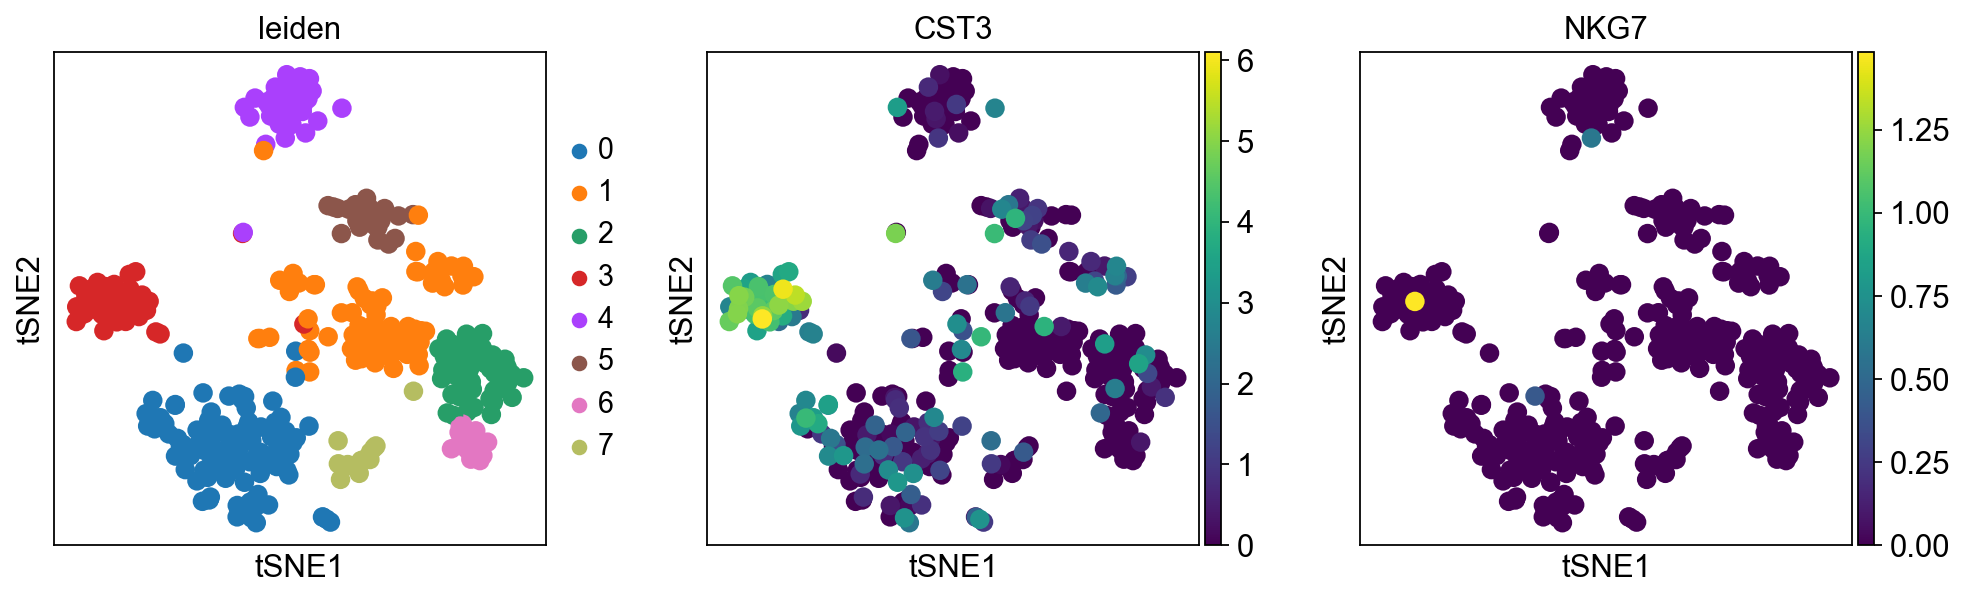

In [115]:
sc.pl.tsne(adata, color=['leiden', 'CST3', 'NKG7'])

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


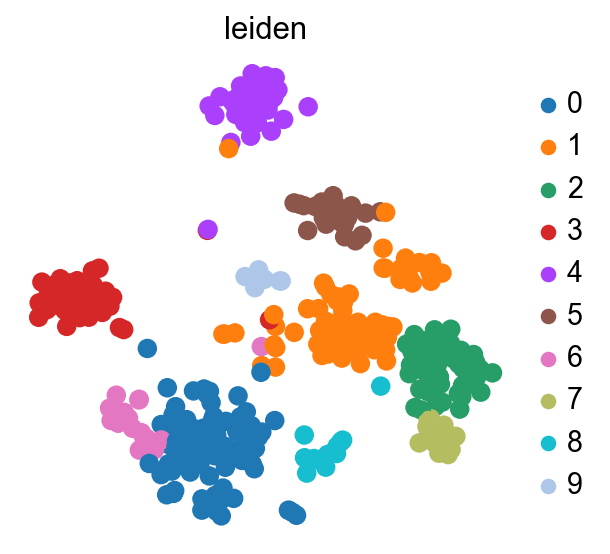

In [116]:
sc.tl.leiden(adata, resolution=1.3)
sc.pl.tsne(adata, color = ['leiden'], frameon = False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


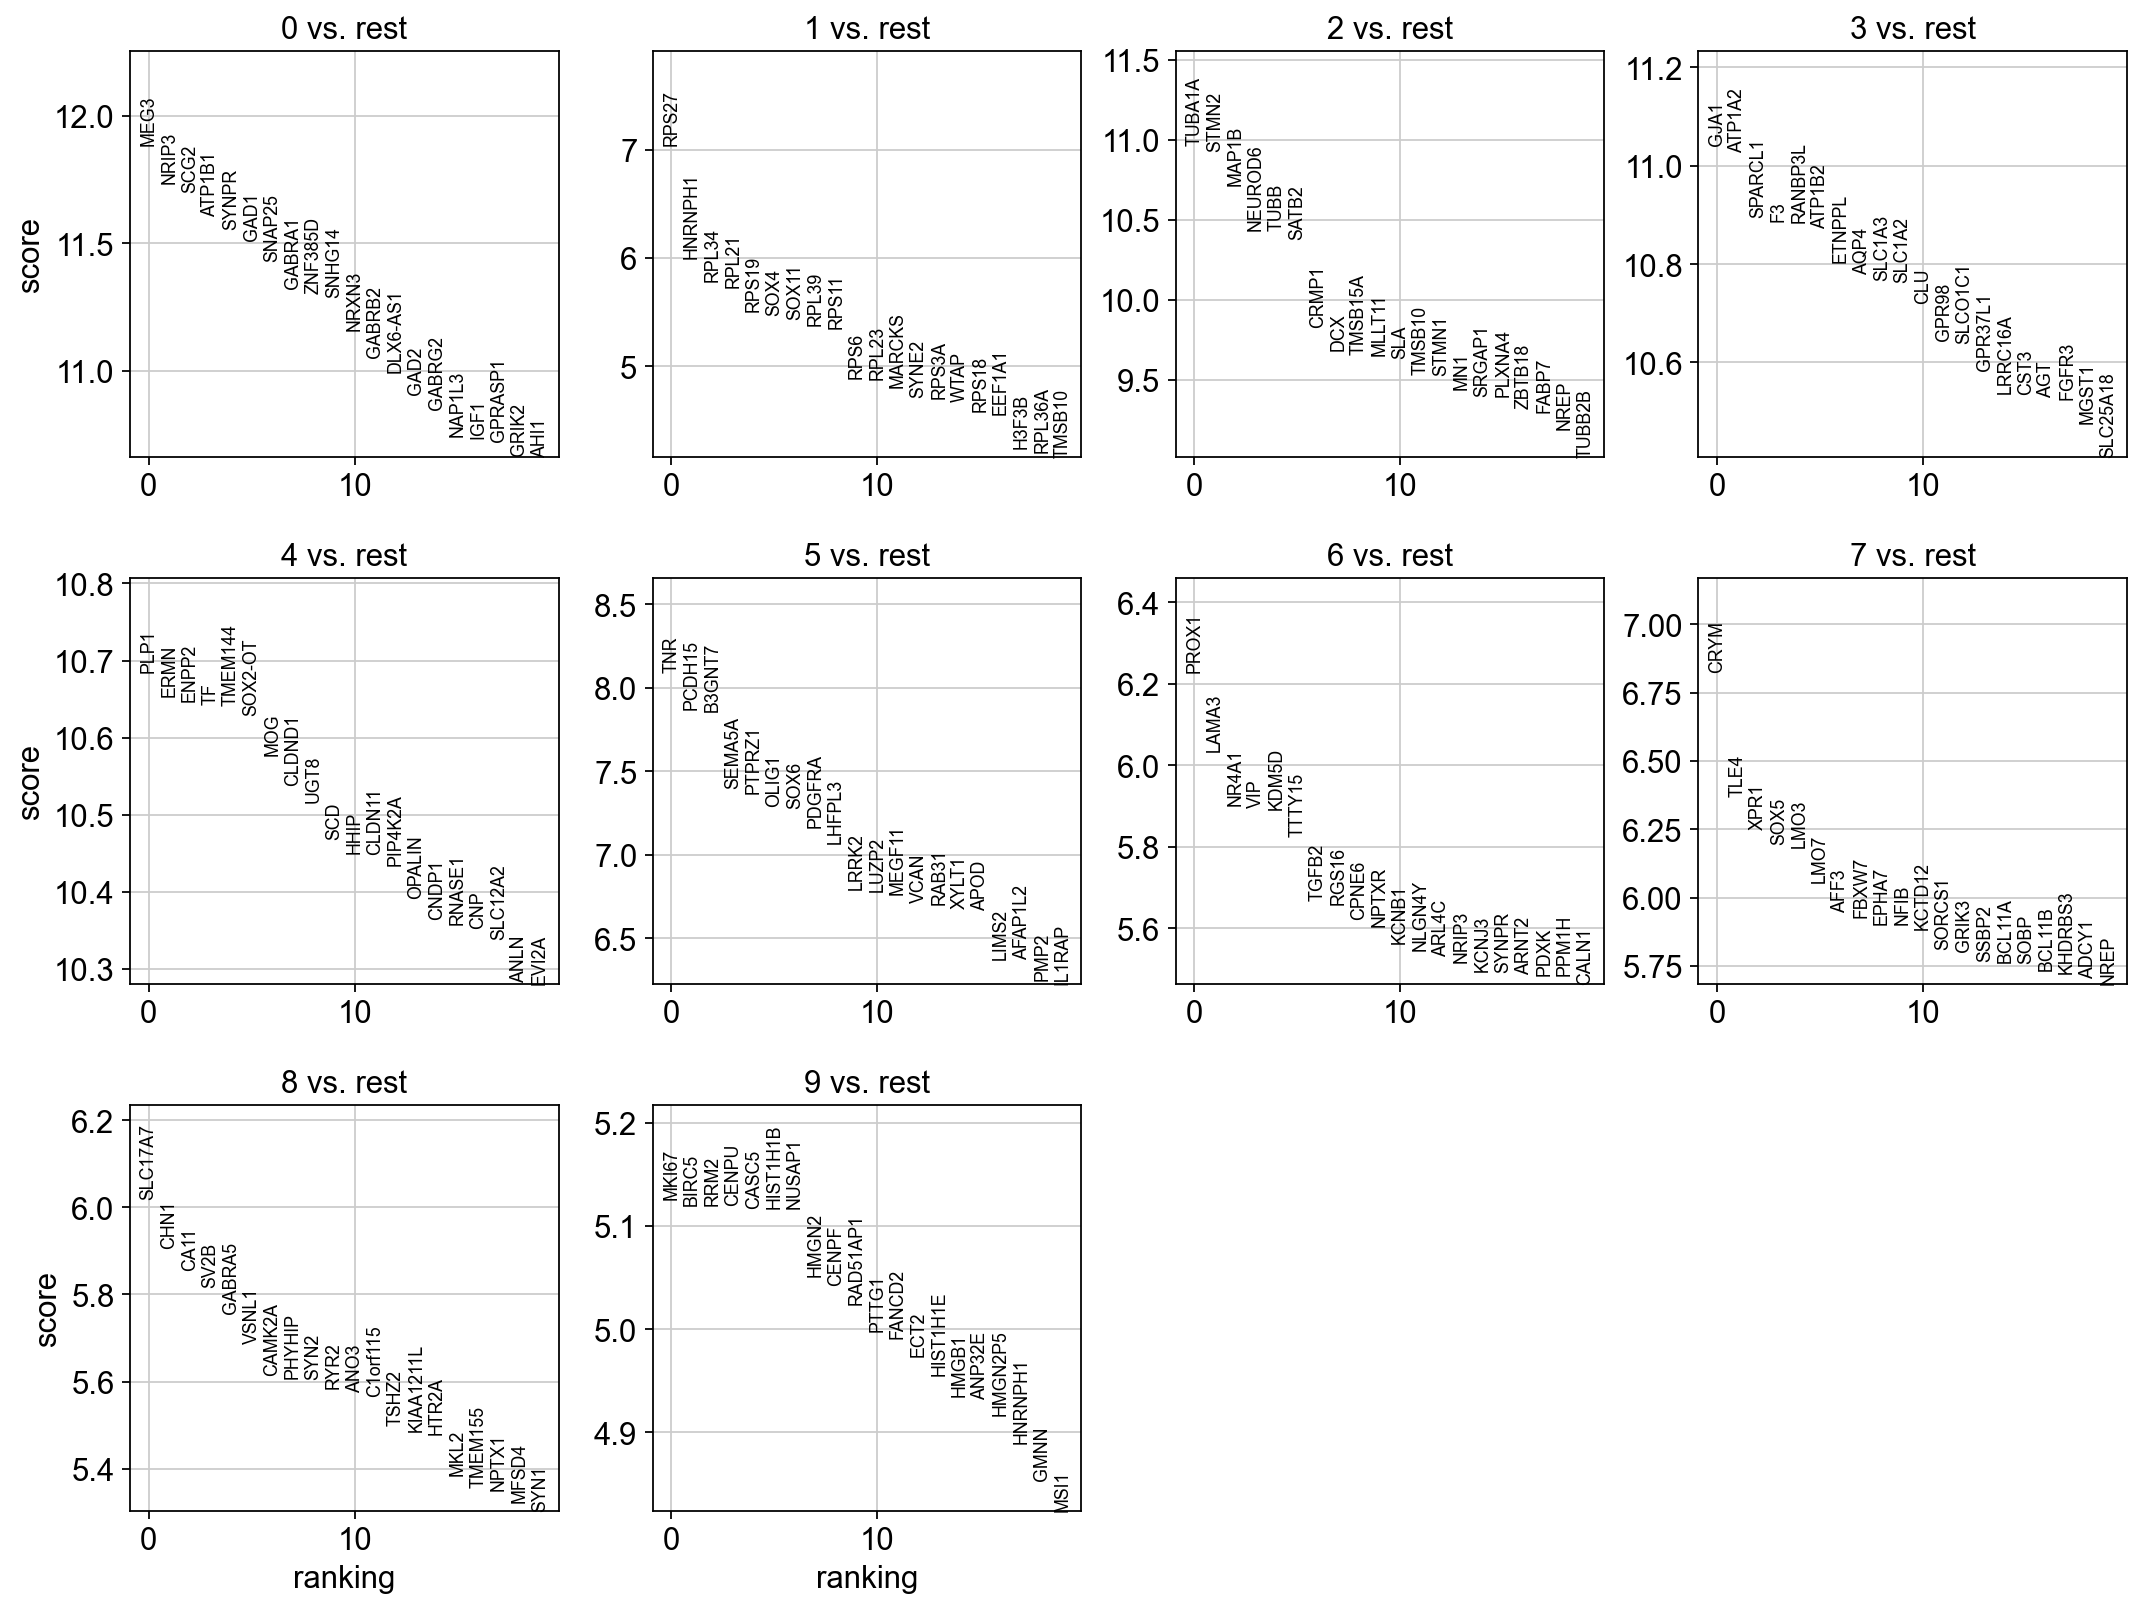

['MEG3' 'NRIP3' 'SCG2' ... 'SCD' 'NHSL1' 'NFIA']


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,MEG3,11.885652,5.765896,1.405346e-32,4.914072e-28
1,0,NRIP3,11.735269,6.351539,8.405943e-32,1.449454e-27
2,0,SCG2,11.702087,6.095642,1.243562e-31,1.449454e-27
3,0,ATP1B1,11.605221,4.453913,3.876837e-31,3.389034e-27
4,0,SYNPR,11.555450,6.676019,6.928347e-31,4.845270e-27
...,...,...,...,...,...,...
349665,9,MYT1L,-3.774034,-8.976316,1.606291e-04,4.287572e-02
349666,9,PRNP,-3.796471,-34.354774,1.467703e-04,4.073110e-02
349667,9,ATP6V0A1,-3.809934,-32.964153,1.390039e-04,3.951666e-02
349668,9,SCG3,-3.865280,-6.496428,1.109616e-04,3.394647e-02


In [117]:
#Plots the top 20 genes per cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

#Identifying the genes in the first cluster
print(adata.uns['rank_genes_groups']['names']['0'])

sc.get.rank_genes_groups_df(adata, None)

In [138]:
#Retaining markers that significantly differentially expressed between clusters
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
#Determine how many cells in each cluster
cluster_sizes = adata.obs.groupby('leiden').size()
print(cluster_sizes)
#Further info on gene counts
furtherinfo = adata.obs.groupby('leiden')["n_genes_by_counts"].sum()
print(furtherinfo)

leiden
0    89
1    75
2    51
3    48
4    43
5    24
6    19
7    19
8    13
9     9
dtype: int64
leiden
0    581431
1    221630
2    210863
3    254721
4    201743
5    116121
6    159684
7     86952
8    104141
9     37312
Name: n_genes_by_counts, dtype: int64


In [134]:
#Get the marker genes for each cluster
marker_genes = {}
for i in adata.uns['rank_genes_groups']['names'].dtype.names:
    marker_genes[i] = adata.uns['rank_genes_groups']['names'][i][:20]
#Print the top 20 marker genes for each cluster
for i in marker_genes.keys():
    print(f'Cluster {i}: {", ".join(marker_genes[i])}')

Cluster 0: MEG3, NRIP3, SCG2, ATP1B1, SYNPR, GAD1, SNAP25, GABRA1, ZNF385D, SNHG14, NRXN3, GABRB2, DLX6-AS1, GAD2, GABRG2, NAP1L3, IGF1, GPRASP1, GRIK2, AHI1
Cluster 1: RPS27, HNRNPH1, RPL34, RPL21, RPS19, SOX4, SOX11, RPL39, RPS11, RPS6, RPL23, MARCKS, SYNE2, RPS3A, WTAP, RPS18, EEF1A1, H3F3B, RPL36A, TMSB10
Cluster 2: TUBA1A, STMN2, MAP1B, NEUROD6, TUBB, SATB2, CRMP1, DCX, TMSB15A, MLLT11, SLA, TMSB10, STMN1, MN1, SRGAP1, PLXNA4, ZBTB18, FABP7, NREP, TUBB2B
Cluster 3: GJA1, ATP1A2, SPARCL1, F3, RANBP3L, ATP1B2, ETNPPL, AQP4, SLC1A3, SLC1A2, CLU, GPR98, SLCO1C1, GPR37L1, LRRC16A, CST3, AGT, FGFR3, MGST1, SLC25A18
Cluster 4: PLP1, ERMN, ENPP2, TF, TMEM144, SOX2-OT, MOG, CLDND1, UGT8, SCD, HHIP, CLDN11, PIP4K2A, OPALIN, CNDP1, RNASE1, CNP, SLC12A2, ANLN, EVI2A
Cluster 5: TNR, PCDH15, B3GNT7, SEMA5A, PTPRZ1, OLIG1, SOX6, PDGFRA, LHFPL3, LRRK2, LUZP2, MEGF11, VCAN, RAB31, XYLT1, APOD, LIMS2, AFAP1L2, PMP2, IL1RAP
Cluster 6: PROX1, LAMA3, NR4A1, VIP, KDM5D, TTTY15, TGFB2, RGS16, CPNE6, NPT

In [120]:
table = 'SraRunTable.txt'

sra_table = pd.read_csv(table)
matrix = pd.read_csv(file, delimiter='\t')

#Samples is a dictionary containing sample identifier as key and a list of cells as values
samples = {}
for index, sample in enumerate(sra_table.experiment_sample_name):
    samples.setdefault(sample, []).append(sra_table.Run[index])

adata.obs['sample_identifier'] = False

In [121]:
#Assigning sample labels
for index, row in enumerate(adata.obs_names):
    for key, value in samples.items():
        if row in value:
            adata.obs.sample_identifier.iloc[index] = key

In [122]:
adata.obs

,scrublet_scores,scrublet_predicted_doublets,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,sample_identifier
SRR1974543,0.121951,False,5019,4984,459287.875000,18652.886719,4.061263,4,AB_S8
SRR1974545,0.061889,False,3734,3623,371774.187500,15834.530273,4.259180,4,AB_S8
SRR1974546,0.138298,False,4636,4576,236967.734375,10817.853516,4.565117,0,AB_S8
SRR1974548,0.085937,False,5466,5460,258048.875000,18724.302734,7.256107,5,AB_S8
SRR1974549,0.096234,False,4136,4127,467417.250000,20668.378906,4.421826,4,AB_S8
...,...,...,...,...,...,...,...,...,...
SRR1975003,0.085937,False,2717,2701,343686.000000,12892.471680,3.751235,1,FB_S6
SRR1975004,0.085937,False,3587,3582,460477.000000,9480.000000,2.058735,2,FB_S6
SRR1975005,0.121951,False,3371,3357,332607.937500,12795.411133,3.846995,2,FB_S6
SRR1975007,0.157895,False,4717,4714,352989.312500,5691.477539,1.612365,2,FB_S6


In [140]:
#Dictionary to name clusters
cell_type = {"0":"NEURONS",
"1":"FETAL REPLICATING",
"2":"FETAL QUIESCENT",
"3":"ASTROCYTES",
"4":"OLIGODENDROCYTES",
"5":"ENDOTHELIAL",
"6":"OLIGODENDROCYTE PROGENITOR CELLS(OPCs)",
"7":"EXCITATORY GLUTAMINERGIC NEURONS",
"8":"HYBRID",
"9":"MICROGLIA",
    }

adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

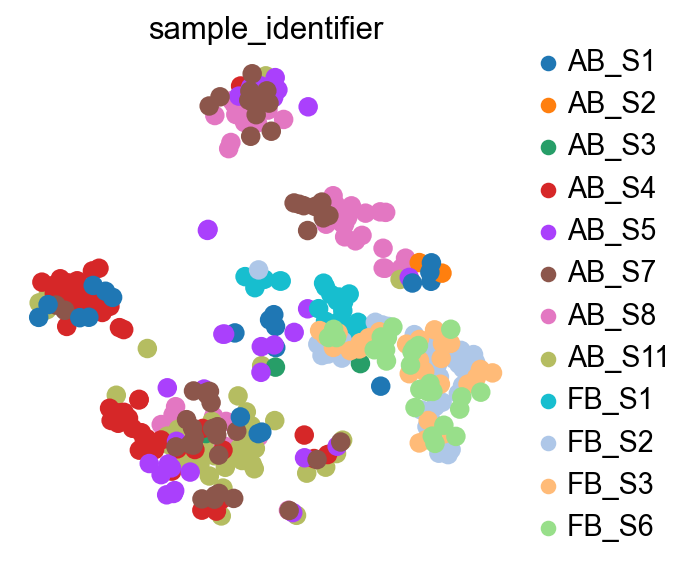

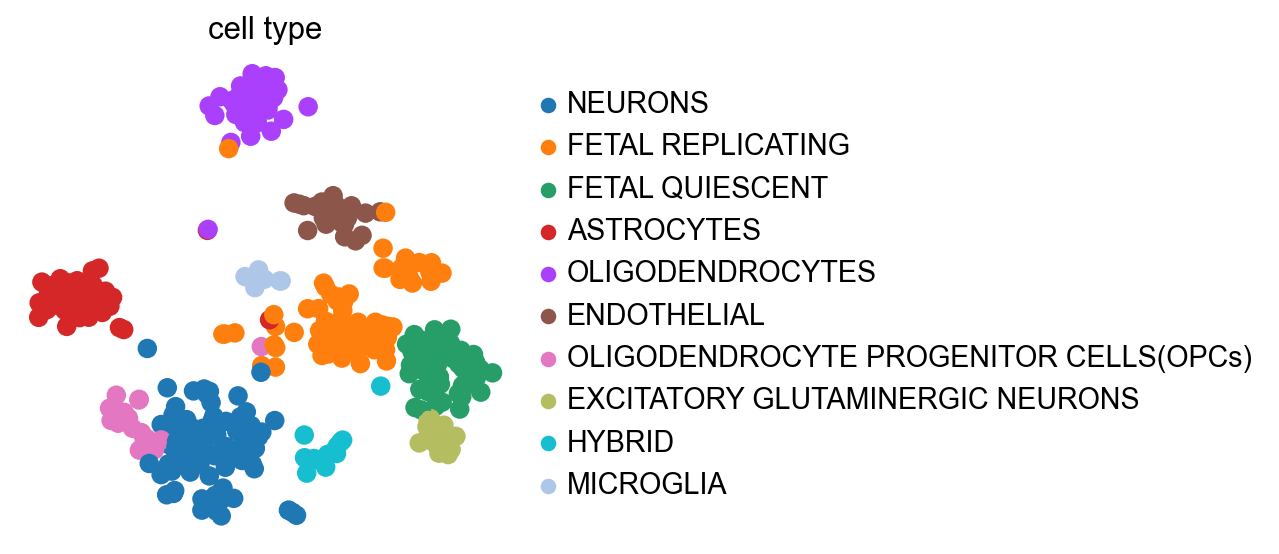

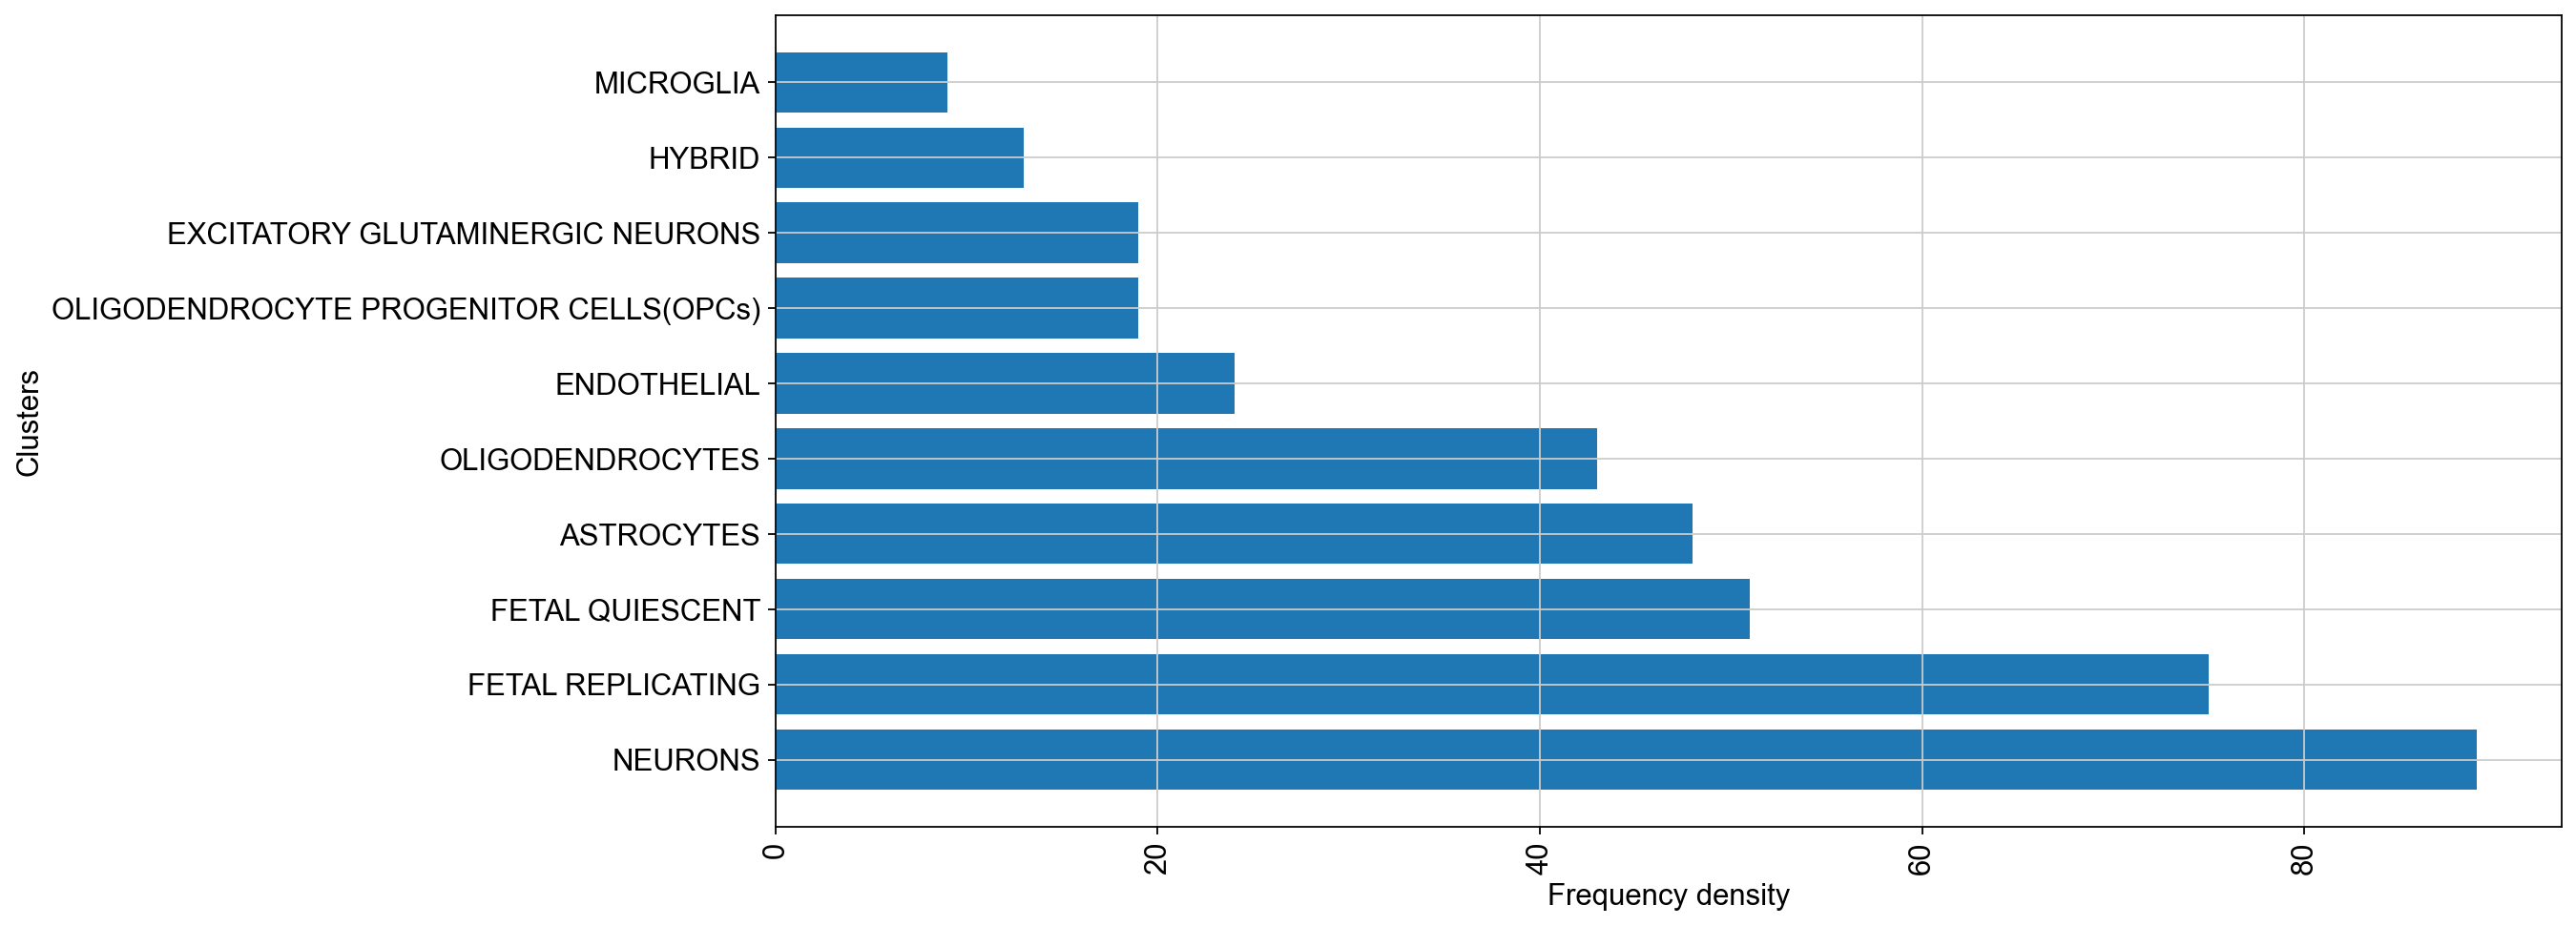

In [141]:
#Further t-SNE graphs
sc.pl.tsne(adata, color = ['sample_identifier'], frameon = False)

sc.pl.tsne(adata, color = ['cell type'], frameon = False,)

plt.figure(figsize=(15, 7))
plt.barh(adata.obs["cell type"].value_counts().index, adata.obs["cell type"].value_counts())
plt.xticks(rotation=90)
plt.ylabel('Clusters')
plt.xlabel('Frequency density');

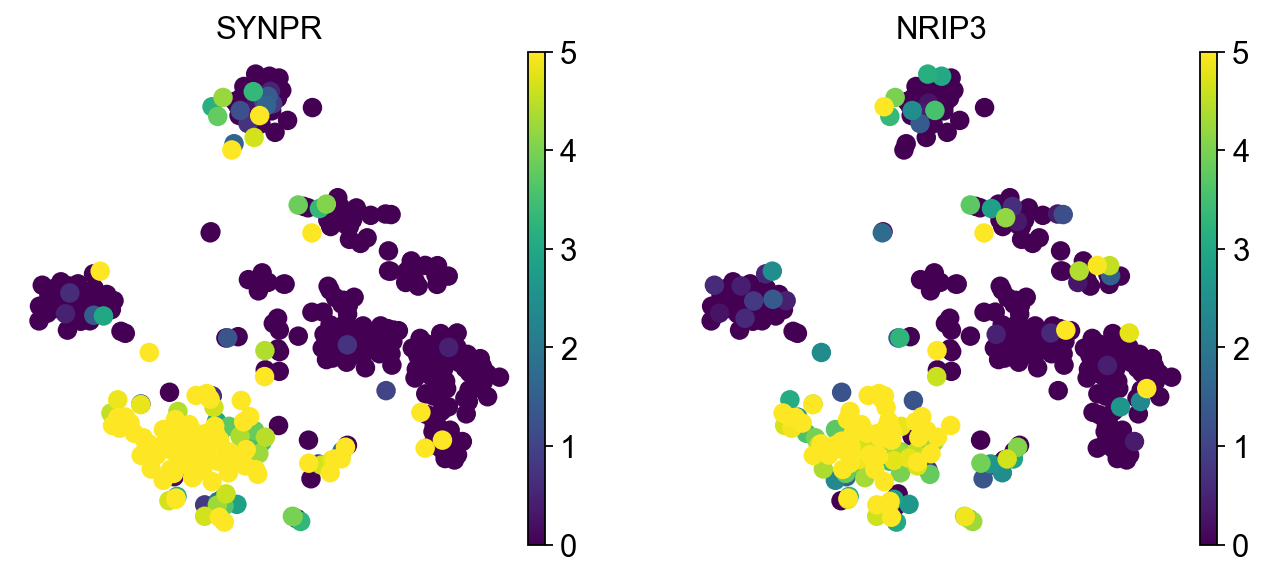

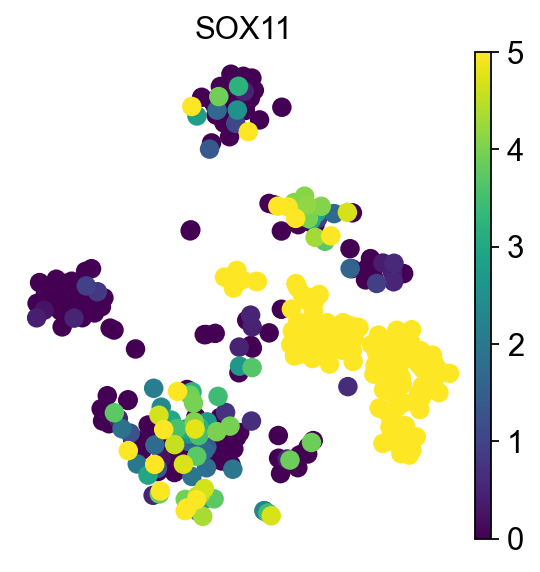

In [126]:
sc.pl.tsne(adata, color = ['SYNPR','NRIP3'], frameon = False, vmax = 5)

sc.pl.tsne(adata, color = ['SOX11'], frameon = False, vmax = 5)

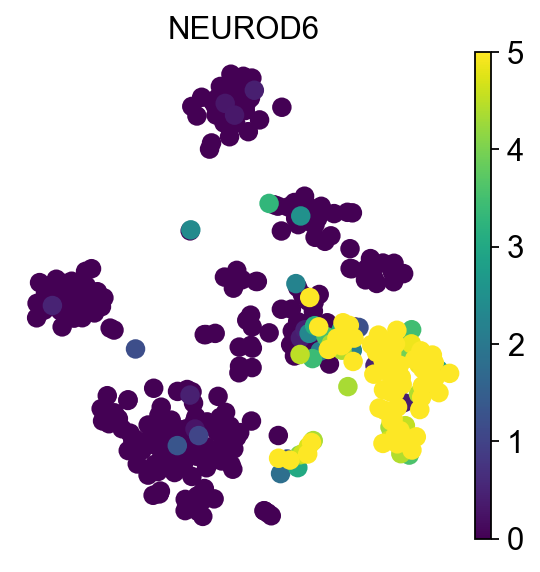

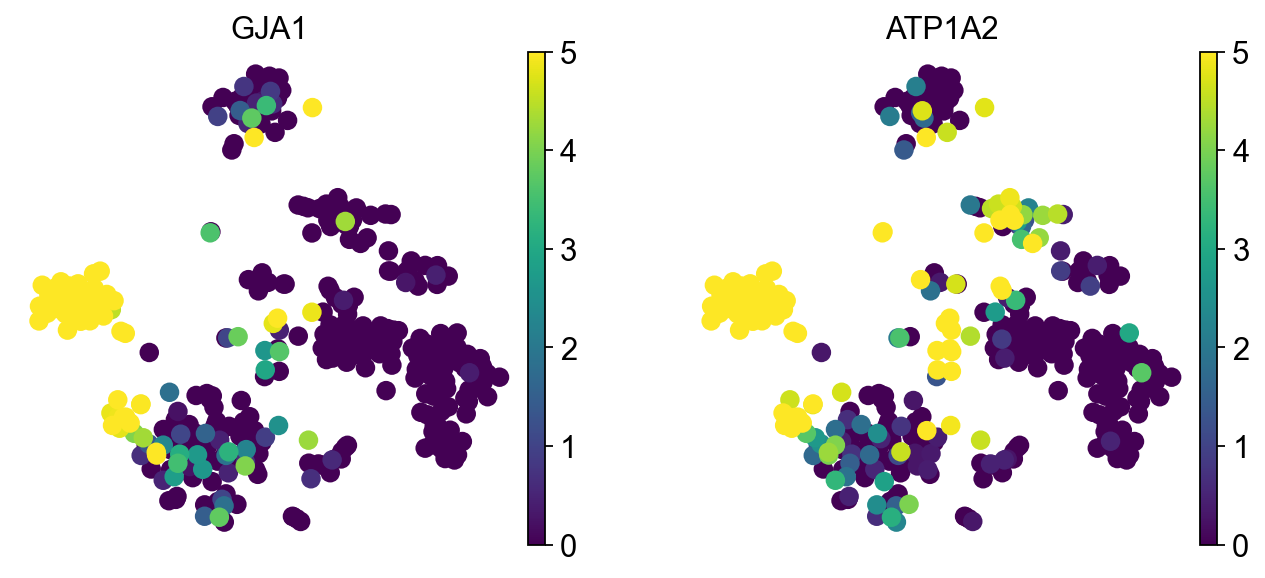

In [127]:
sc.pl.tsne(adata, color = ['NEUROD6'], frameon = False, vmax = 5)

sc.pl.tsne(adata, color = ['GJA1','ATP1A2'], frameon = False, vmax = 5)

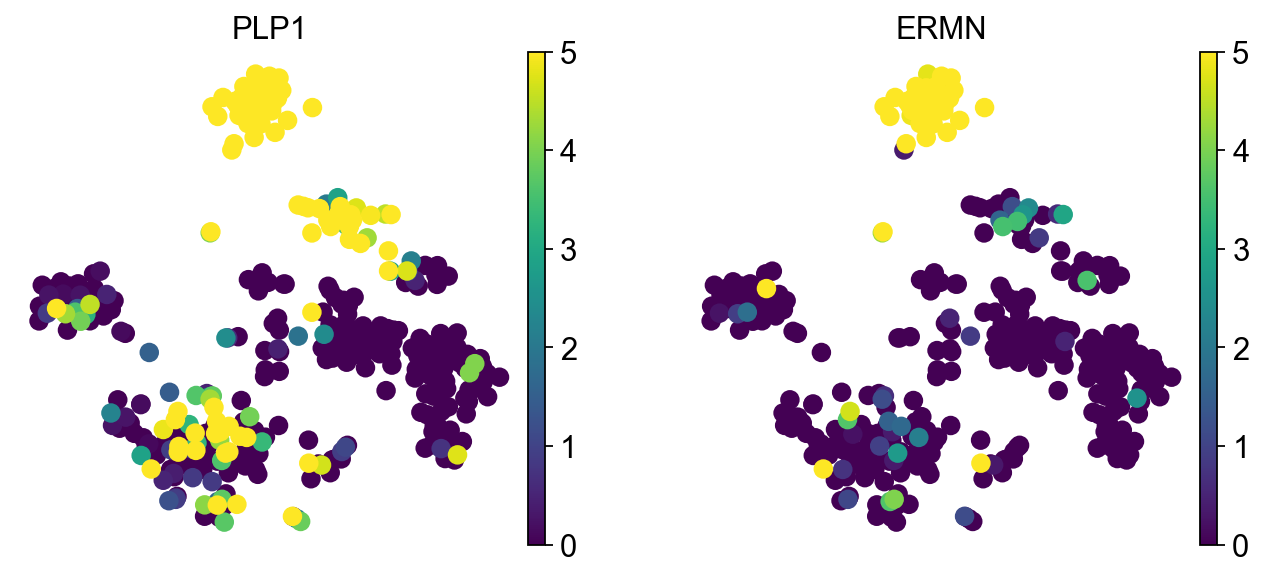

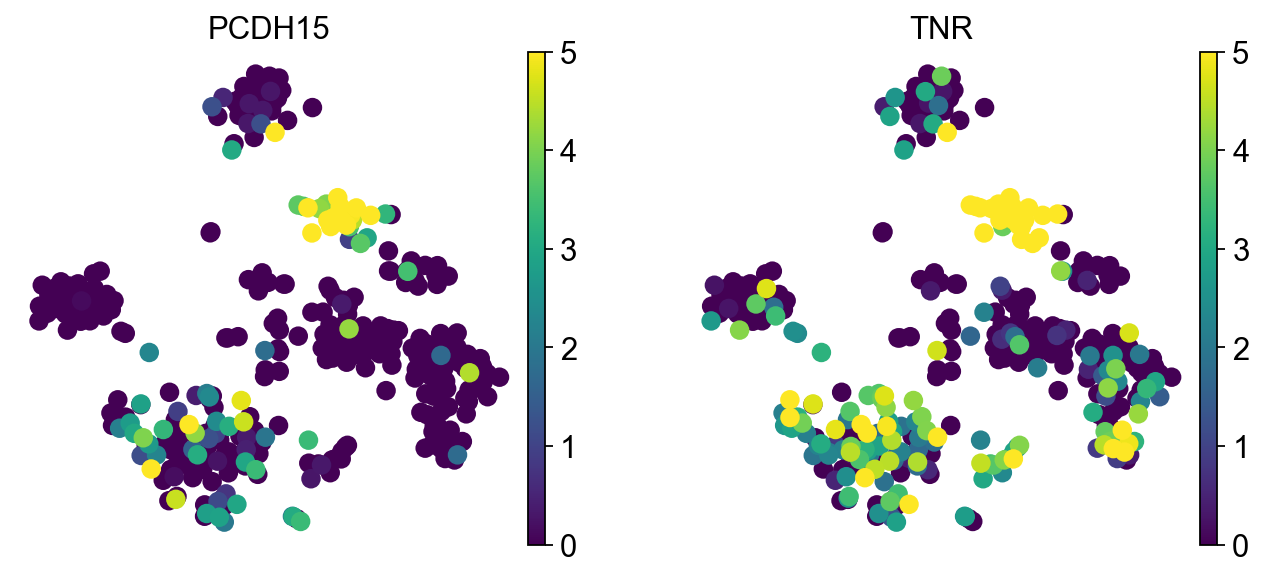

In [128]:
sc.pl.tsne(adata, color = ['PLP1','ERMN'], frameon = False, vmax = 5)

sc.pl.tsne(adata, color = ['PCDH15','TNR'], frameon = False, vmax = 5)

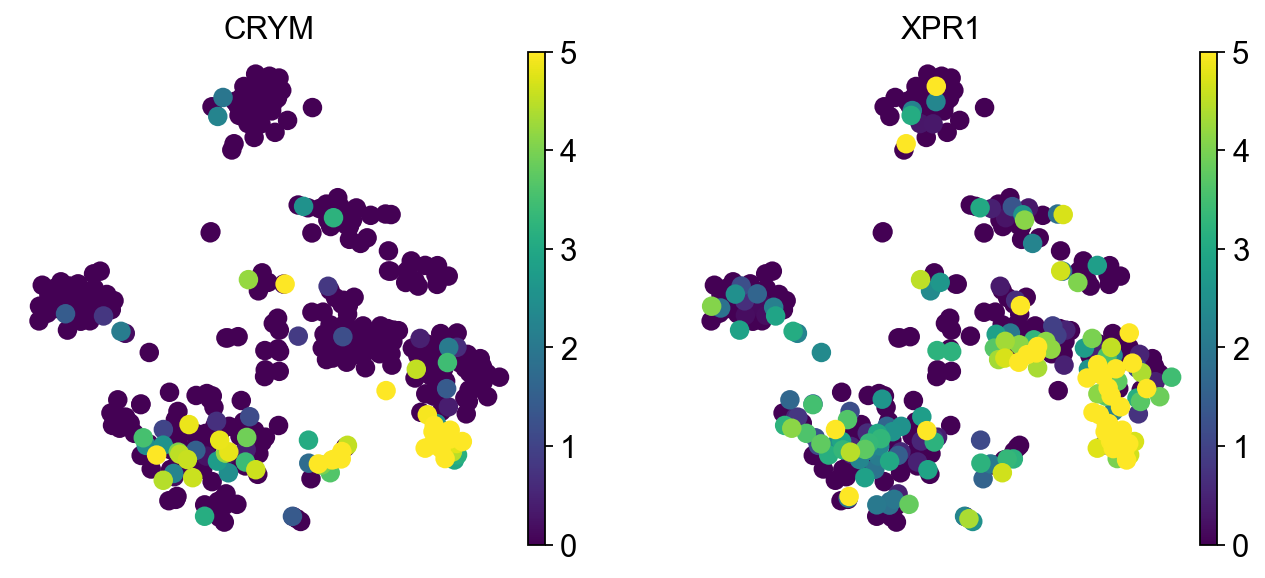

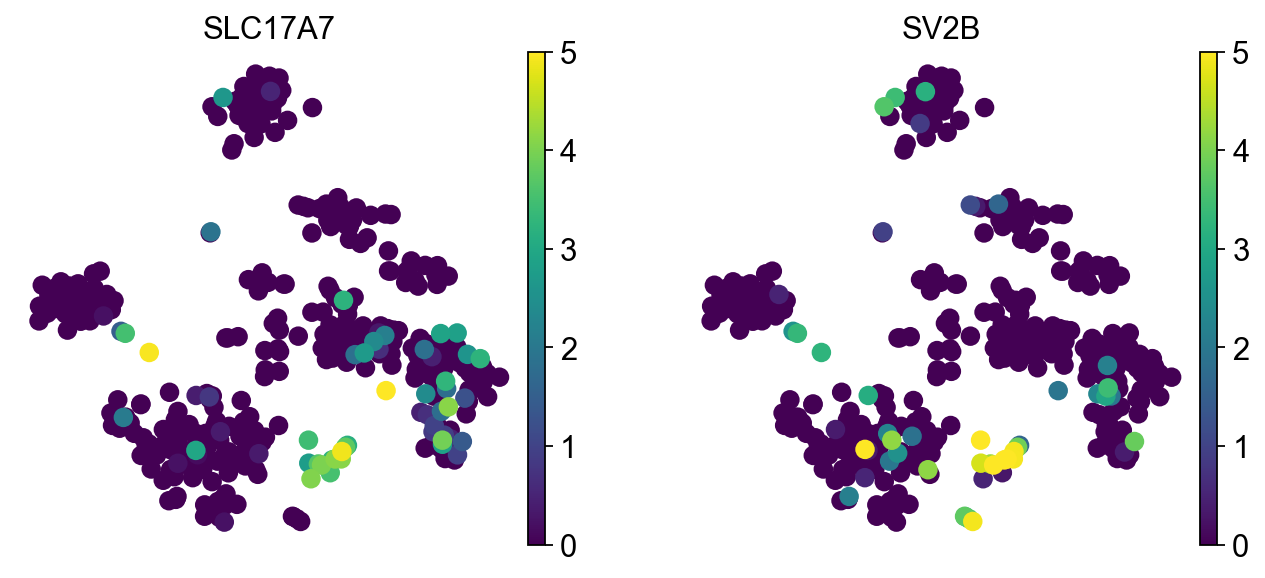

In [129]:
sc.pl.tsne(adata, color = ['CRYM','XPR1'], frameon = False, vmax = 5)

sc.pl.tsne(adata, color = ['SLC17A7', 'SV2B'], frameon = False, vmax = 5)

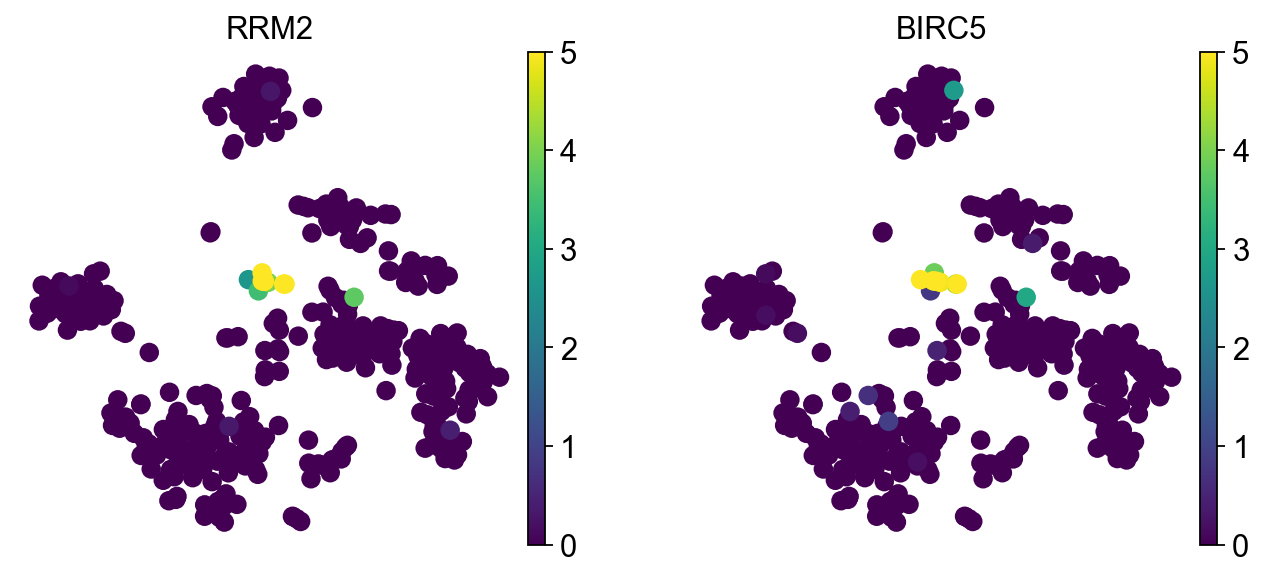

In [130]:
sc.pl.tsne(adata, color = ['RRM2', 'BIRC5'], frameon = False, vmax = 5)

In [131]:
#Cross-validate marker genes by comparing the logfoldchanges
markers[markers.names == 'RRM2']

,group,names,scores,logfoldchanges,pvals,pvals_adj
314705,9,RRM2,5.1203,12.669186,3.050500e-07,0.001548
